In [8]:
import pandas as pd
import numpy as np

from scipy.optimize import minimize
from scipy.special import gamma
from scipy.special import gammaln
from scipy.optimize import differential_evolution

from tqdm import tqdm
from modeling_parameters.config import (
    MATPLOTLIBRC_PATH,
    COORDINATES_PATH,
)

import matplotlib as mpl
mpl.rc_file(MATPLOTLIBRC_PATH)
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors

from matplotlib.backends.backend_pdf import PdfPages
from concurrent.futures import ThreadPoolExecutor, as_completed
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
from functions import compute_r, rho_model, log_rho_model, compute_r_fast

plt.style.use('ggplot')

In [3]:
coordinates_df = pd.read_csv('../data/coordinates.csv')

n_events = 100

X = coordinates_df['X']
Y = coordinates_df['Y']
Z = coordinates_df['Z']


Ne, s = 1e6, 1.2
theta, phi = 30, 210
Z0 = - 18
X0_array = np.random.uniform(-40, 40, size=n_events)
Y0_array = np.random.uniform(-70, 70, size=n_events)

initial_params = [0,  0,  1e5, 1.5]
bounds = [
    (-50, 50),  # X0
    (-80, 80),  # Y0
    (1, 1e8),  # Ne
    (0.2, 2)  # s
]

In [5]:
def loss_function(params, coordinates_df, rho, theta, phi, Z0):
    eps = 1e-10 
    X0, Y0, Ne, s = params
    X_det, Y_det, Z_det = coordinates_df[['X', 'Y', 'Z']].values.T
    r = compute_r(X0, Y0, Z0, theta, phi, X_det, Y_det, Z_det)
    rho_calc = rho_model(r, Ne, s)
    return np.mean((np.log(rho_calc + eps) - np.log(rho + eps)) ** 2)

In [6]:
def add_noise(rho, noise_level=0.1, threshold=None):
    """Добавляет гауссов шум к значениям rho"""
    noise = np.random.normal(loc=0, scale=noise_level *
                             np.abs(rho), size=rho.shape)
    rho_noisy = rho + noise
    if threshold is not None:
        rho_noisy = np.maximum(rho_noisy, threshold)
        
    return rho_noisy

In [7]:
def find_params(coordinates, theta, phi, X0_array, Y0_array, Z0, Ne, s, n_clusters=9, noise_level=0):
    r_list, rho_list = [], []
    X0_list, Y0_list = [], []
    Ne_list, s_list = [], []
    mrpe_list = []
    R_list, RHO_list = [], []
    used_clusters_list = []
    rho_noisy_list = []
    
    unique_clusters = coordinates['cluster'].unique()
    
    threshold = 1 * 8.2 /  (0.4 * 0.4 * 4)

    for i in tqdm(range(n_events), desc="Processing events"):
        # случайный выбор кластеров
        selected_clusters = np.random.choice(unique_clusters, size=n_clusters, replace=False)
        used_clusters_list.append(selected_clusters)
        
        # фильтрация по кластерам
        cluster_mask = coordinates['cluster'].isin(selected_clusters)
        selected_coords = coordinates[cluster_mask].copy()  # Создаем копию для безопасности
        
        X_det_all, Y_det_all, Z_det_all = selected_coords[['X', 'Y', 'Z']].values.T
        
        # r и rho для выбранных кластеров
        X0, Y0 = X0_array[i], Y0_array[i]
        r_all = compute_r(X0, Y0, Z0, theta, phi, X_det_all, Y_det_all, Z_det_all)
        rho_all = rho_model(r_all, Ne, s)
        
        # фильтрация по порогу
        threshold_mask = rho_all >= threshold
        final_coords = selected_coords[threshold_mask]
        final_rho = rho_all[threshold_mask]
        rho_noisy = add_noise(final_rho, noise_level=noise_level, threshold=threshold * 3 / 4)
        final_r = r_all[threshold_mask]
        
        if len(final_rho) == 0:
            continue  

        X_det, Y_det, Z_det = final_coords[['X', 'Y', 'Z']].values.T

        result = differential_evolution(
            loss_function,
            bounds,
            args=(final_coords, rho_noisy, theta, phi, Z0)
        )
        
        result = minimize(
            loss_function, 
            result.x, 
            args=(final_coords, rho_noisy, theta, phi, Z0),
            method='Nelder-Mead', 
            bounds=bounds
        )
        
        X0_opt, Y0_opt, Ne_opt, s_opt = result.x
        
        R = compute_r(X0_opt, Y0_opt, Z0, theta, phi, X_det, Y_det, Z_det)
        RHO = rho_model(R, Ne_opt, s_opt)
        
        mrpe = np.mean(np.abs((RHO - rho_noisy) / rho_noisy))
        
        mrpe_list.append(mrpe)
        r_list.append(final_r)
        R_list.append(R)
        rho_list.append(final_rho)
        rho_noisy_list.append(rho_noisy)
        RHO_list.append(RHO)
        X0_list.append(X0_opt)
        Y0_list.append(Y0_opt)
        Ne_list.append(Ne_opt)
        s_list.append(s_opt)

    return (
        r_list,
        R_list,
        rho_list,
        rho_noisy_list,
        RHO_list,
        X0_list,
        Y0_list,
        Ne_list,
        s_list,
        mrpe_list,
        threshold_mask
    )

In [8]:
noise_level = 20

In [9]:
results  = find_params(coordinates_df, theta, phi, X0_array, Y0_array, Z0, Ne, s, n_clusters=5, noise_level=noise_level / 100)
r_array, R_array, rho_array, rho_noisy_array, RHO_array, X0_opt_array, Y0_opt_array, Ne_opt_array, s_opt_array, mrpe_array, mask = results

Processing events:   1%|          | 1/100 [00:02<03:29,  2.12s/it]

: 

In [ ]:
results1  = find_params(coordinates_df, theta, phi, X0_array, Y0_array, Z0, Ne=1e5, s=1.2, n_clusters=5, noise_level=noise_level / 100)
r_array1, R_array1, rho_array1, rho_noisy_array1, RHO_array1, X0_opt_array1, Y0_opt_array1, Ne_opt_array1, s_opt_array1, mrpe_array1, mask1 = results1

Processing events: 100%|██████████| 100/100 [23:36<00:00, 14.17s/it]


In [ ]:
delta_X0 = np.array(X0_opt_array) - np.array(X0_array)
delta_Y0 = np.array(Y0_opt_array) - np.array(Y0_array)
delta_Ne = [(Ne_opt - Ne) / Ne for Ne_opt in Ne_opt_array]
delta_s = [(s_opt - s) / s for s_opt in s_opt_array]

In [11]:
np.mean(mrpe_array)

0.13829249332020177

In [35]:
plt.style.use('default')

In [23]:
delta_X0 = np.asarray(delta_X0)
delta_Y0 = np.asarray(delta_Y0)
delta_Ne = np.asarray(delta_Ne)
delta_s = np.asarray(delta_s)

# Теперь можно использовать булеву индексацию
delta_X0[np.abs(delta_X0) > 20] = 0
delta_Y0[np.abs(delta_Y0) > 20] = 0
delta_Ne[np.abs(delta_Ne) > 1] = 0
delta_s[np.abs(delta_s) > 1] = 0

In [24]:
def find_limit(nums):
    return abs(max(nums, key=lambda x: abs(x)))

In [25]:
print(f"Ne = {Ne:.2e}, s = {s}")

Ne = 1.00e+06, s = 1.2


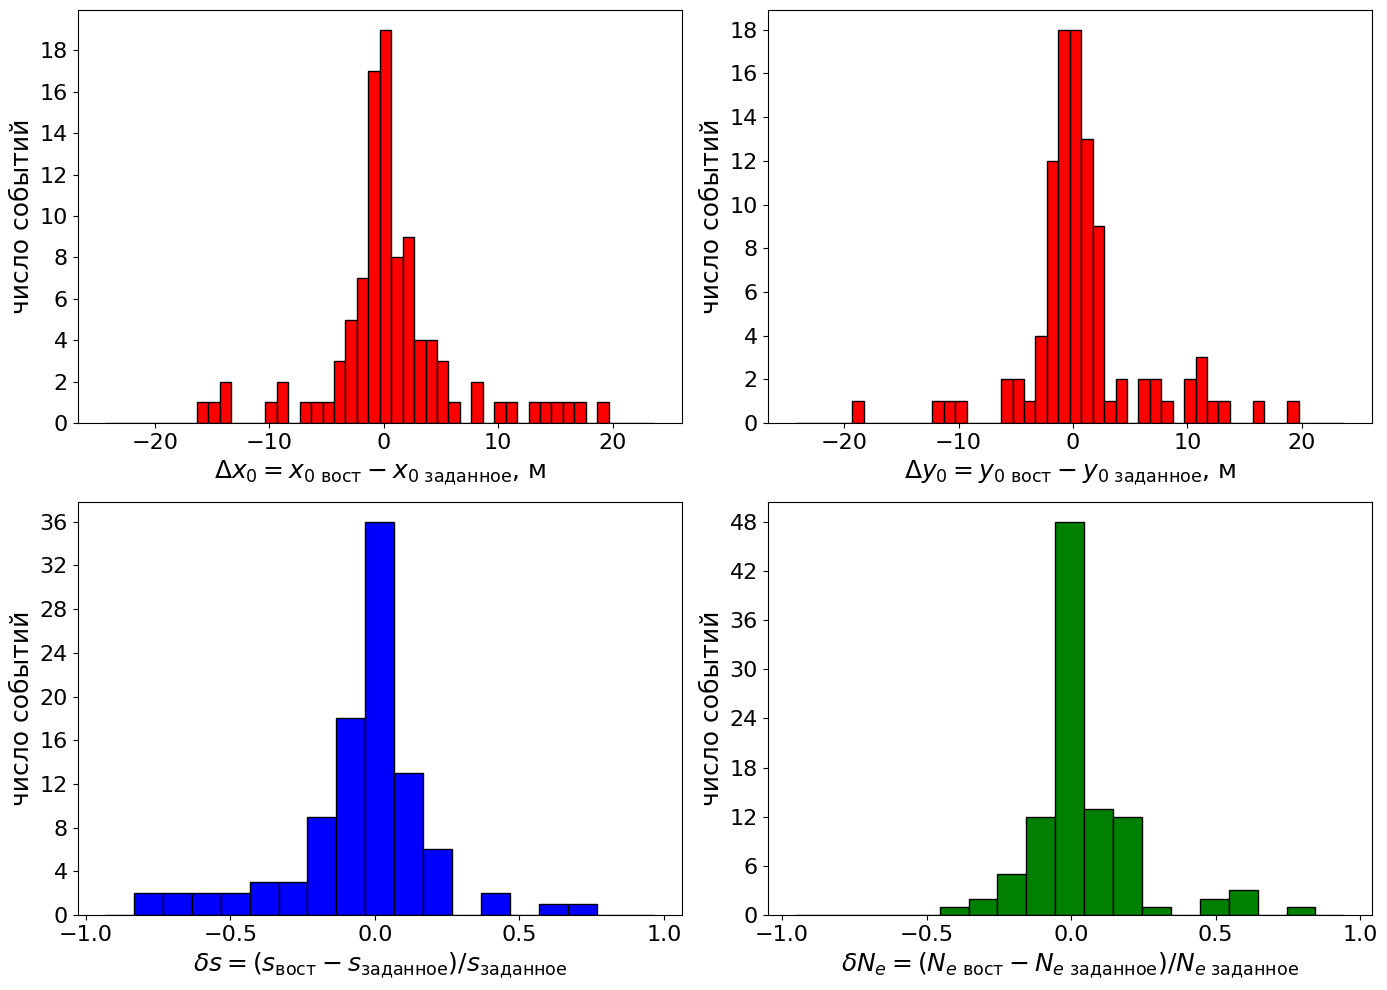

In [44]:
interval_delta_X = 1
interval_delta_Y = 1

interval_delta_s = 0.1
interval_delta_Ne = 0.1

limit_X, limit_Y = find_limit(delta_X0), find_limit(delta_Y0)
limit_Ne, limit_s = find_limit(delta_Ne), find_limit(delta_s)

bin_edges_delta_X = np.arange(-limit_X - 5, limit_X + 5, interval_delta_X)
bin_edges_delta_Y = np.arange(-limit_Y - 5, limit_Y + 5, interval_delta_Y)

bin_edges_delta_s = np.arange(-limit_s - 0.1, limit_s + 0.15, interval_delta_s)
bin_edges_delta_Ne = np.arange(-limit_Ne - 0.2, limit_Ne + 0.2, interval_delta_Ne)


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# fig.suptitle(r'$Ne=1\times10^6,\ s=1.2,\ \text{число кластеров}=5,\ \text{шум}\ 20\%$', fontsize=18)
# delta_X
axes[0, 0].hist(delta_X0, bins=bin_edges_delta_X,
                edgecolor='black', color='red', label=f'размер интервала: {interval_delta_X}')
axes[0, 0].set_xlabel(
    r'$\Delta x_0 = x_{0~\text{вост}} - x_{0~\text{заданное}}$, м', fontsize=18)
axes[0, 0].set_ylabel("число событий", fontsize=18)
axes[0, 0].tick_params(axis='both', which='major', labelsize=16) 


# delta_Y
axes[0, 1].hist(delta_Y0, bins=bin_edges_delta_Y,
                edgecolor='black', color='red', label=f'размер интервала: {interval_delta_Y}')
axes[0, 1].set_xlabel(
    r'$\Delta y_0 = y_{0~\text{вост}} - y_{0~\text{заданное}}$, м', fontsize=18)
axes[0, 1].set_ylabel("число событий", fontsize=18)
axes[0, 1].tick_params(axis='both', which='major', labelsize=16) 
# delta_s
axes[1, 0].hist(delta_s, bins=bin_edges_delta_s, edgecolor='black',
                color='blue', label=f'размер интервала: {interval_delta_s}')
axes[1, 0].set_xlabel(
    r'$\delta s = (s_{\text{вост}} - s_{\text{заданное}}) / s_{\text{заданное}}$',  fontsize=18)
axes[1, 0].set_ylabel("число событий",  fontsize=18)
axes[1, 0].tick_params(axis='both', which='major', labelsize=16)
axes[1, 0].xaxis.set_major_locator(ticker.MultipleLocator(0.5)) 
# delta_Ne
axes[1, 1].hist(delta_Ne, bins=bin_edges_delta_Ne,
                edgecolor='black', color='green', label=f'размер интервала: {interval_delta_Ne}')
axes[1, 1].set_xlabel(
    r'$\delta N_e = (N_{e~\text{вост}} - N_{e~\text{заданное}}) / N_{e~\text{заданное}}$',  fontsize=18)
axes[1, 1].set_ylabel("число событий",  fontsize=18)
axes[1, 1].tick_params(axis='both', which='major', labelsize=16) 
axes[1, 1].xaxis.set_major_locator(ticker.MultipleLocator(0.5)) 
for ax in axes.flat:
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# data = pd.DataFrame(
#     {'delta_r': np.array(delta_r).reshape(-1, 36).tolist, 'delta_s': delta_s, 'delta_Ne': delta_Ne})
# data.to_csv(f'plots/{model_number}/delta_r,s,Ne.csv', index=False)

plt.tight_layout()
plt.savefig(
    f'plots_testing/Ne=1e6_s=1.2/delta_r,s=1.2,Ne=1e6,clasters=5_noise0{noise_level}_legendoff.png',
    dpi=1200,                     # Разрешение 
    bbox_inches='tight',          # Обрезка пустых полей
    pad_inches=0.1,               # Отступ внутри bbox_inches
    format='png',                 # Формат 
    facecolor='white',            # Фон 
    edgecolor='none',             # Убрать границу вокруг
)

# fig.legend()
# plt.savefig(f'plots_testing/Ne=1e6_s=1.2/delta_r,s=1.2,Ne=1e6,clasters=5_noise0{noise_level}.png',
#             dpi=500, bbox_inches="tight")
plt.show()

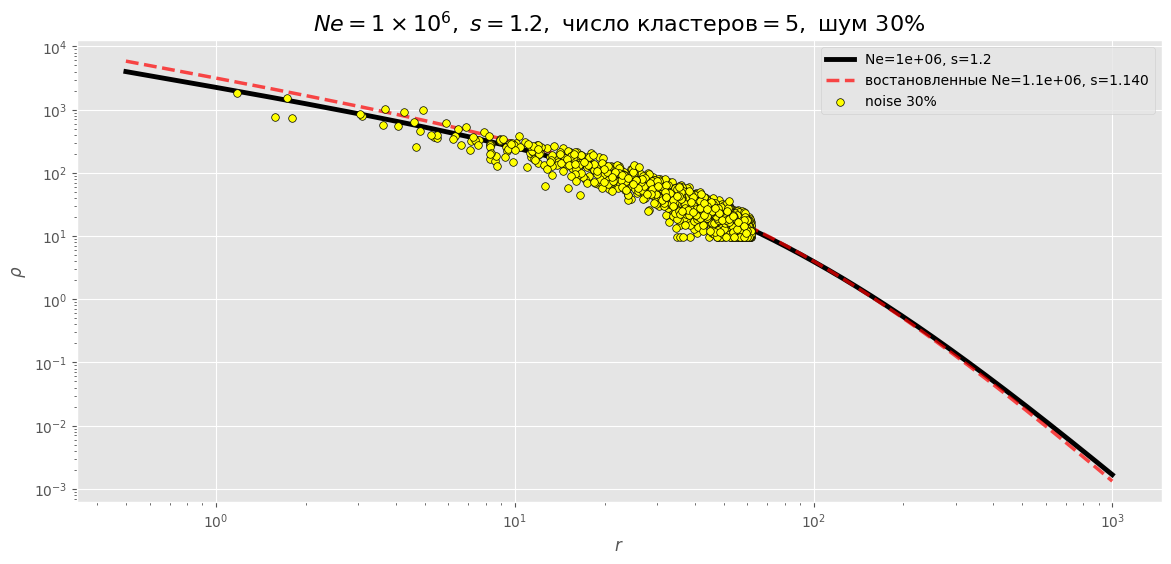

In [334]:
r = np.arange(0, 1e3, 0.5)
rho = rho_model(r, Ne, s)

Ne_opt = np.median(Ne_opt_array)
s_opt = np.median(s_opt_array)
rho_opt = rho_model(r, Ne_opt, s_opt)

all_r = np.concatenate(r_array)
all_rho = np.concatenate(rho_noisy_array)

plt.figure(figsize=(14, 6))
plt.title(r'$Ne=1\times10^6,\ s=1.2,\ \text{число кластеров}=5,\ \text{шум}\ 30\%$', fontsize=16)
plt.plot(r, rho, 
         label=f"Ne={Ne:.0e}, s={s}",
         color='black',
         linestyle='-',
         linewidth=3.5,
         alpha=1,
         zorder=1)

plt.plot(r, rho_opt,
         label=f"востановленные Ne={Ne_opt:.1e}, s={s_opt:.3f}", 
         color='red',
         linestyle='--',
         linewidth=2.5,
         alpha=0.7,
         zorder=2)

plt.scatter(all_r, all_rho,
            label=f"noise {noise_level}%",
            marker='o',
            s=30,
            color='yellow',
            edgecolor='black',
            alpha=1,
            zorder=3)


plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho$")
plt.legend()
plt.grid(True)
plt.savefig(f'plots_testing/Ne=1e6_s=1.2/rho(r),Ne=1e6,clasters=5_noise0{noise_level}.png',
            dpi=500, bbox_inches="tight")
plt.show()

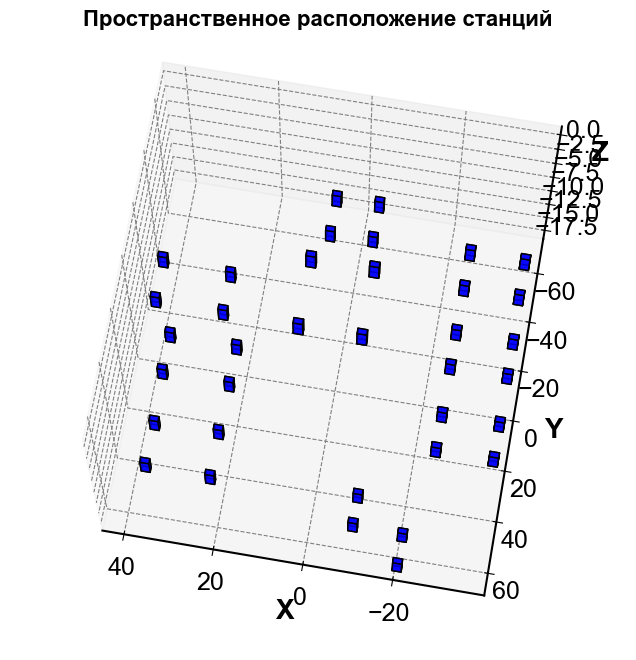

In [22]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

df = coordinates_df

cube_size = 2
def draw_cube(ax, x, y, z, size, color):
    r = [-size/2, size/2]
    vertices = [[x+r[i], y+r[j], z+r[k]] for i in range(2) for j in range(2) for k in range(2)]
    faces = [
        [vertices[0], vertices[1], vertices[3], vertices[2]],  # Bottom face
        [vertices[4], vertices[5], vertices[7], vertices[6]],  # Top face
        [vertices[0], vertices[1], vertices[5], vertices[4]],  # Front face
        [vertices[2], vertices[3], vertices[7], vertices[6]],  # Back face
        [vertices[0], vertices[2], vertices[6], vertices[4]],  # Left face
        [vertices[1], vertices[3], vertices[7], vertices[5]],  # Right face
    ]
    ax.add_collection3d(Poly3DCollection(faces, color=color, edgecolor="k", alpha=0.8))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for _, row in df.iterrows():
    color = "b"
    draw_cube(ax, row["X"], row["Y"], row["Z"], cube_size, color)

ax.set_xlim(df["X"].min() - 1, df["X"].max() + 1)
ax.set_ylim(df["Y"].min() - 1, df["Y"].max() + 1)
ax.set_zlim(df["Z"].min() - 1, df["Z"].max() + 1)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(elev=70, azim=100)
ax.set_title("Пространственное расположение станций")

plt.show()

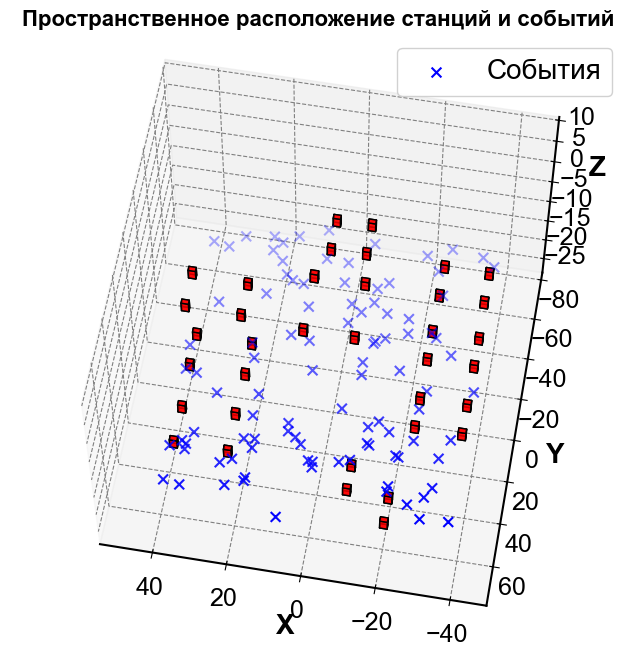

In [23]:
# Функция для отрисовки куба (станции)
def draw_cube(ax, x, y, z, size, color):
    r = [-size / 2, size / 2]
    vertices = [[x + r[i], y + r[j], z + r[k]] for i in range(2) for j in range(2) for k in range(2)]
    faces = [
        [vertices[0], vertices[1], vertices[3], vertices[2]],  # Нижняя грань
        [vertices[4], vertices[5], vertices[7], vertices[6]],  # Верхняя грань
        [vertices[0], vertices[1], vertices[5], vertices[4]],  # Передняя грань
        [vertices[2], vertices[3], vertices[7], vertices[6]],  # Задняя грань
        [vertices[0], vertices[2], vertices[6], vertices[4]],  # Левая грань
        [vertices[1], vertices[3], vertices[7], vertices[5]],  # Правая грань
    ]
    ax.add_collection3d(Poly3DCollection(faces, color=color, edgecolor="k", alpha=0.8))

# Создание 3D-графика
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Отрисовка станций
cube_size = 2
for _, row in df.iterrows():
    draw_cube(ax, row["X"], row["Y"], row["Z"], cube_size, color="red")

# Добавление случайных событий (X0_array, Y0_array, Z0) в виде синих крестиков
ax.scatter(X0_array, Y0_array, Z0, color="blue", marker="x", s=50, label="События")

# Настройки осей и вида
ax.set_xlim(df["X"].min() - 10, df["X"].max() + 10)
ax.set_ylim(df["Y"].min() - 10, df["Y"].max() + 10)
ax.set_zlim(Z0 - 10, df["Z"].max() + 10)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(elev=60, azim=100)
ax.set_title("Пространственное расположение станций и событий")

# Добавление легенды
ax.legend()

# Отображение графика
plt.show()

C:\Users\matsvei\AppData\Local\Temp\ipykernel_21948\2655423359.py:10: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((row["X"] - cube_size/2, row["Y"] - cube_size/2),


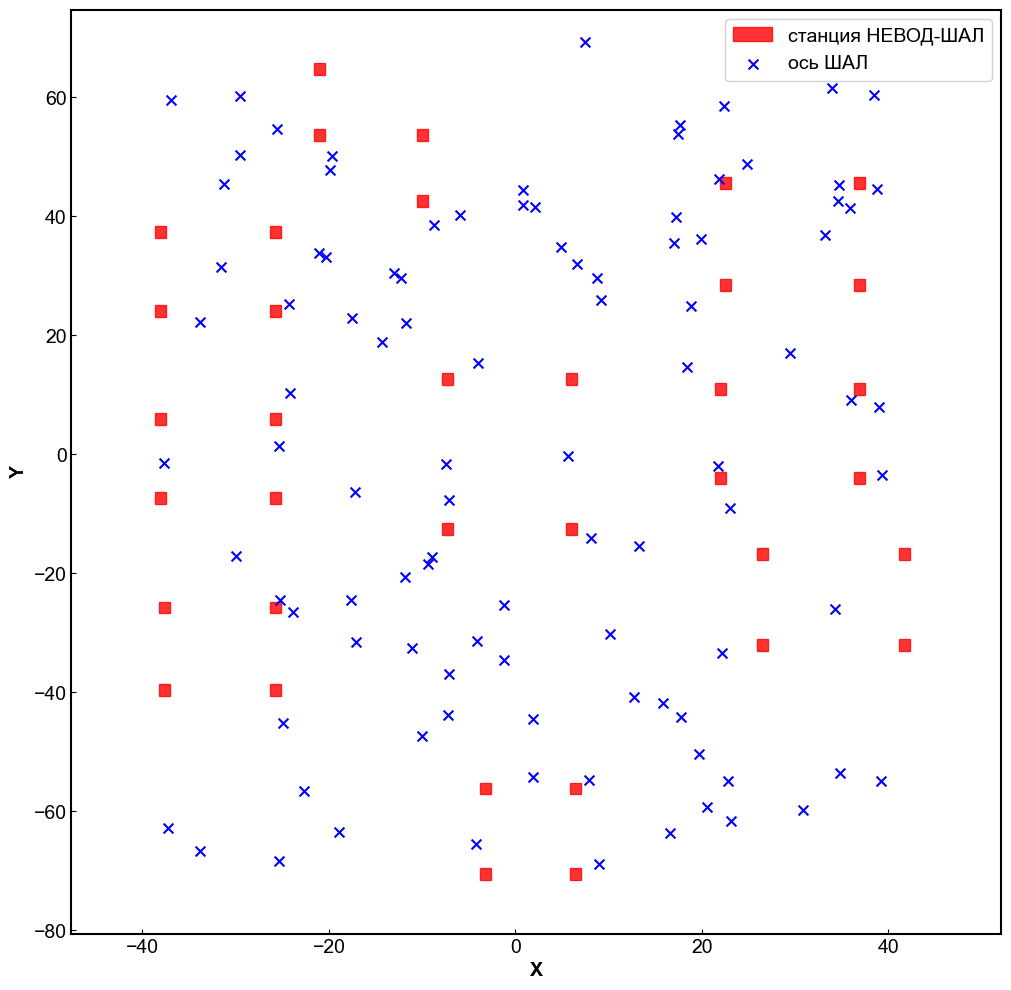

In [24]:
import matplotlib.pyplot as plt

# Создание 2D-графика
fig, ax = plt.subplots(figsize=(12, 12))

# Добавление первого квадрата с легендой, остальные — без неё
first_station = True
for _, row in df.iterrows():
    label = "станция НЕВОД-ШАЛ" if first_station else None  # Легенда только для первого элемента
    ax.add_patch(plt.Rectangle((row["X"] - cube_size/2, row["Y"] - cube_size/2), 
                               cube_size/1.7, cube_size, color="red", alpha=0.8, edgecolor="k", label=label))
    first_station = False  # После первого квадрата убираем легенду
# Добавление случайных событий (синие крестики)
ax.scatter(X0_array, Y0_array, color="blue", marker="x", s=50, label="ось ШАЛ")

# Добавление легенды
ax.legend(fontsize=14)
# Настройки осей
ax.set_xlim(df["X"].min() - 10, df["X"].max() + 10)
ax.set_ylim(df["Y"].min() - 10, df["Y"].max() + 10)
ax.set_xlabel("X", fontsize=14)
ax.set_ylabel("Y", fontsize=14)
ax.tick_params(axis='both', labelsize=14)


# Отображение графика
plt.show()


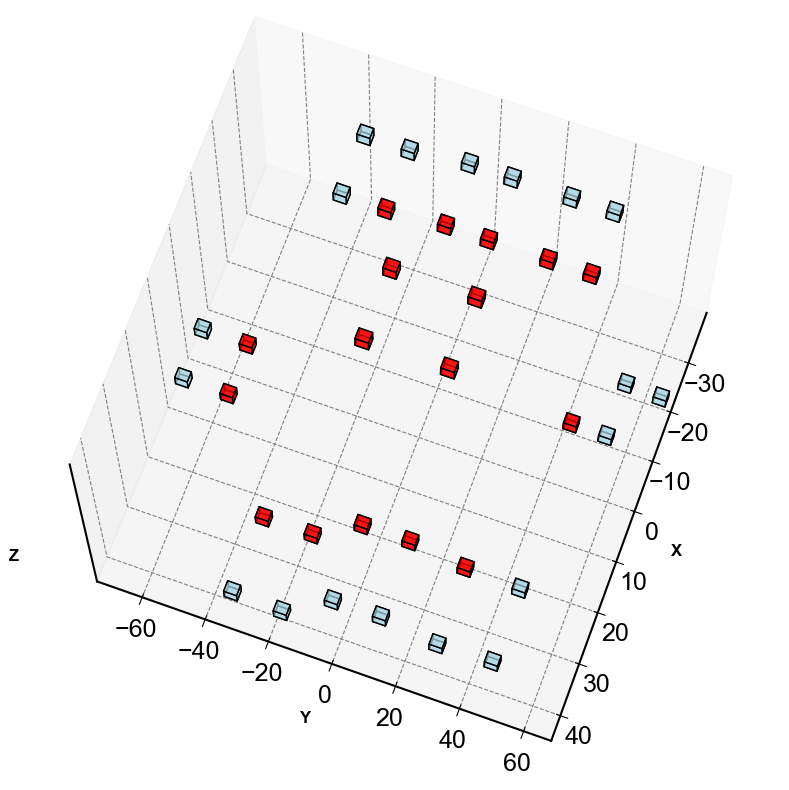

In [53]:
cube_size = 2

# Функция для отрисовки куба
def draw_cube(ax, x, y, z, size, color):
    r = [-size/2, size/2]
    vertices = [[x+r[i], y+r[j] * 2, z+r[k]/2] for i in range(2) for j in range(2) for k in range(2)]
    faces = [
        [vertices[0], vertices[1], vertices[3], vertices[2]],  # Bottom face
        [vertices[4], vertices[5], vertices[7], vertices[6]],  # Top face
        [vertices[0], vertices[1], vertices[5], vertices[4]],  # Front face
        [vertices[2], vertices[3], vertices[7], vertices[6]],  # Back face
        [vertices[0], vertices[2], vertices[6], vertices[4]],  # Left face
        [vertices[1], vertices[3], vertices[7], vertices[5]],  # Right face
    ]
    ax.add_collection3d(Poly3DCollection(faces, color=color, edgecolor="k", linewidths=1, alpha=0.7))

# Создание 3D-фигуры
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Отрисовка станций
for _, row in df.iterrows():
    color = "red" if row["station"] in central_stations else "lightblue"
    draw_cube(ax, row["X"], row["Y"], row["Z"], cube_size, color)

# Установка правильных границ осей с небольшим отступом
ax.set_xlim(df["X"].min() - 1, df["X"].max() + 1)
ax.set_ylim(df["Y"].min() - 1, df["Y"].max() + 1)
ax.set_zlim(df["Z"].min() - 1, df["Z"].max() + 1)

# Настройки графика
ax.set_xlabel("X", fontsize=12, labelpad=10)
ax.set_ylabel("Y", fontsize=12, labelpad=10)
ax.set_zlabel("Z", fontsize=12, labelpad=10)

ax.set_zticks([])
# Заголовок

# Добавление легенды
from matplotlib.lines import Line2D


# Установка углов просмотра для более красивой перспективы
ax.view_init(elev=70, azim=20)

# Показ графика
plt.show()

In [111]:
coordinates_df = pd.read_csv('../data/coordinates.csv')

n_events = 100

X = coordinates_df['X']
Y = coordinates_df['Y']
Z = coordinates_df['Z']


Ne, s = 1e5, 1.2
theta, phi = 30, 210
Z0 = - 18
X0_array = np.random.uniform(-40, 40, size=n_events)
Y0_array = np.random.uniform(-70, 70, size=n_events)

initial_params = [0,  0,  1e5, 1.5]
bounds = [
    (-50, 50),  # X0
    (-80, 80),  # Y0
    (1, 1e8),  # Ne
    (0.2, 2)  # s
]

In [ ]:
def find_params(coordinates, theta, phi, X0_array, Y0_array, Z0, Ne, s, n_clusters=9, noise_level=0):
    # Инициализируем списки длины n_events для соответсвия входным массивам
    r_list = [None] * n_events
    rho_list = [None] * n_events
    X0_list = [np.nan] * n_events
    Y0_list = [np.nan] * n_events
    Ne_list = [np.nan] * n_events
    s_list = [np.nan] * n_events
    mrpe_list = [np.nan] * n_events
    R_list = [None] * n_events
    RHO_list = [None] * n_events
    used_clusters_list = [None] * n_events
    rho_noisy_list = [None] * n_events
    selected_events_mask = [False] * n_events
    
    unique_clusters = coordinates['cluster'].unique()
    threshold = 1 * 8.2 / (0.4 * 0.4 * 4)

    for i in tqdm(range(n_events), desc="Processing events"):
        # случайный выбор кластеров
        selected_clusters = np.random.choice(unique_clusters, size=n_clusters, replace=False)
        used_clusters_list[i] = selected_clusters
        
        # фильтрация по кластерам
        cluster_mask = coordinates['cluster'].isin(selected_clusters)
        selected_coords = coordinates[cluster_mask].copy()  # Создаем копию для безопасности
        
        X_det_all, Y_det_all, Z_det_all = selected_coords[['X', 'Y', 'Z']].values.T
        
        # r и rho для выбранных кластеров
        X0_val, Y0_val = X0_array[i], Y0_array[i]
        r_all = compute_r(X0_val, Y0_val, Z0, theta, phi, X_det_all, Y_det_all, Z_det_all)
        rho_all = rho_model(r_all, Ne, s)
        
        # фильтрация по порогу
        event_threshold_mask = rho_all >= threshold
        final_coords = selected_coords[event_threshold_mask]
        final_rho = rho_all[event_threshold_mask]
        rho_noisy = add_noise(final_rho, noise_level=noise_level, threshold=threshold * 3 / 4)
        
        # Если нет детекторов, удовлетворяющих порогу, оставляем значение NaN и маску False
        if len(rho_noisy) == 0:
            continue
        final_r = r_all[event_threshold_mask]
        
        X_det, Y_det, Z_det = final_coords[['X', 'Y', 'Z']].values.T

        # Определяем индексы 4 станций с максимальными rho
        top_4_indices = np.argsort(final_rho)[-4:] 
        top_4_stations = final_coords.iloc[top_4_indices]["station"].values

        # Проверяем, входят ли все 4 в центральные станции
        if not all(station in central_stations for station in top_4_stations):
            continue  

        # Если событие прошло фильтр, отмечаем его в маске
        selected_events_mask[i] = True
        
        # Оптимизация параметров
        result = differential_evolution(
            loss_function,
            bounds,
            args=(final_coords, rho_noisy, theta, phi, Z0)
        )
        
        result = minimize(
            loss_function, 
            result.x, 
            args=(final_coords, rho_noisy, theta, phi, Z0),
            method='Nelder-Mead', 
            bounds=bounds
        )
        
        X0_opt, Y0_opt, Ne_opt, s_opt = result.x
        
        R = compute_r(X0_opt, Y0_opt, Z0, theta, phi, X_det, Y_det, Z_det)
        RHO = rho_model(R, Ne_opt, s_opt)
        
        mrpe = np.mean(np.abs((RHO - rho_noisy) / rho_noisy))

        mrpe_list[i] = mrpe
        r_list[i] = final_r
        R_list[i] = R
        rho_list[i] = final_rho
        rho_noisy_list[i] = rho_noisy
        RHO_list[i] = RHO
        X0_list[i] = X0_opt
        Y0_list[i] = Y0_opt
        Ne_list[i] = Ne_opt
        s_list[i] = s_opt

    return (
        r_list,
        R_list,
        rho_list,
        rho_noisy_list,
        RHO_list,
        X0_list,
        Y0_list,
        Ne_list,
        s_list,
        mrpe_list,
        selected_events_mask
    )


In [123]:
noise_level = 20

In [ ]:
results  = find_params(coordinates_df, theta, phi, X0_array, Y0_array, Z0, Ne, s, n_clusters=9, noise_level=noise_level / 100)
r_array, R_array, rho_array, rho_noisy_array, RHO_array, X0_opt_array, Y0_opt_array, Ne_opt_array, s_opt_array, mrpe_array, events_mask = results

Processing events: 100%|██████████| 100/100 [12:35<00:00,  7.56s/it]


ValueError: not enough values to unpack (expected 12, got 11)

In [125]:
r_array, R_array, rho_array, rho_noisy_array, RHO_array, X0_opt_array, Y0_opt_array, Ne_opt_array, s_opt_array, mrpe_array, events_mask = results

In [126]:
len(Ne_opt_array)

100

Locator attempting to generate 12454 ticks ([-623.0000000000001, ..., 622.3000000000001]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 12454 ticks ([-623.0000000000001, ..., 622.3000000000001]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 12454 ticks ([-623.0000000000001, ..., 622.3000000000001]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 12454 ticks ([-623.0000000000001, ..., 622.3000000000001]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 12454 ticks ([-623.0000000000001, ..., 622.3000000000001]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 12454 ticks ([-623.0000000000001, ..., 622.3000000000001]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 12454 ticks ([-623.0000000000001, ..., 622.3000000000001]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 12454 ticks ([-623.0000000000001, ..., 622.3000000000001]),

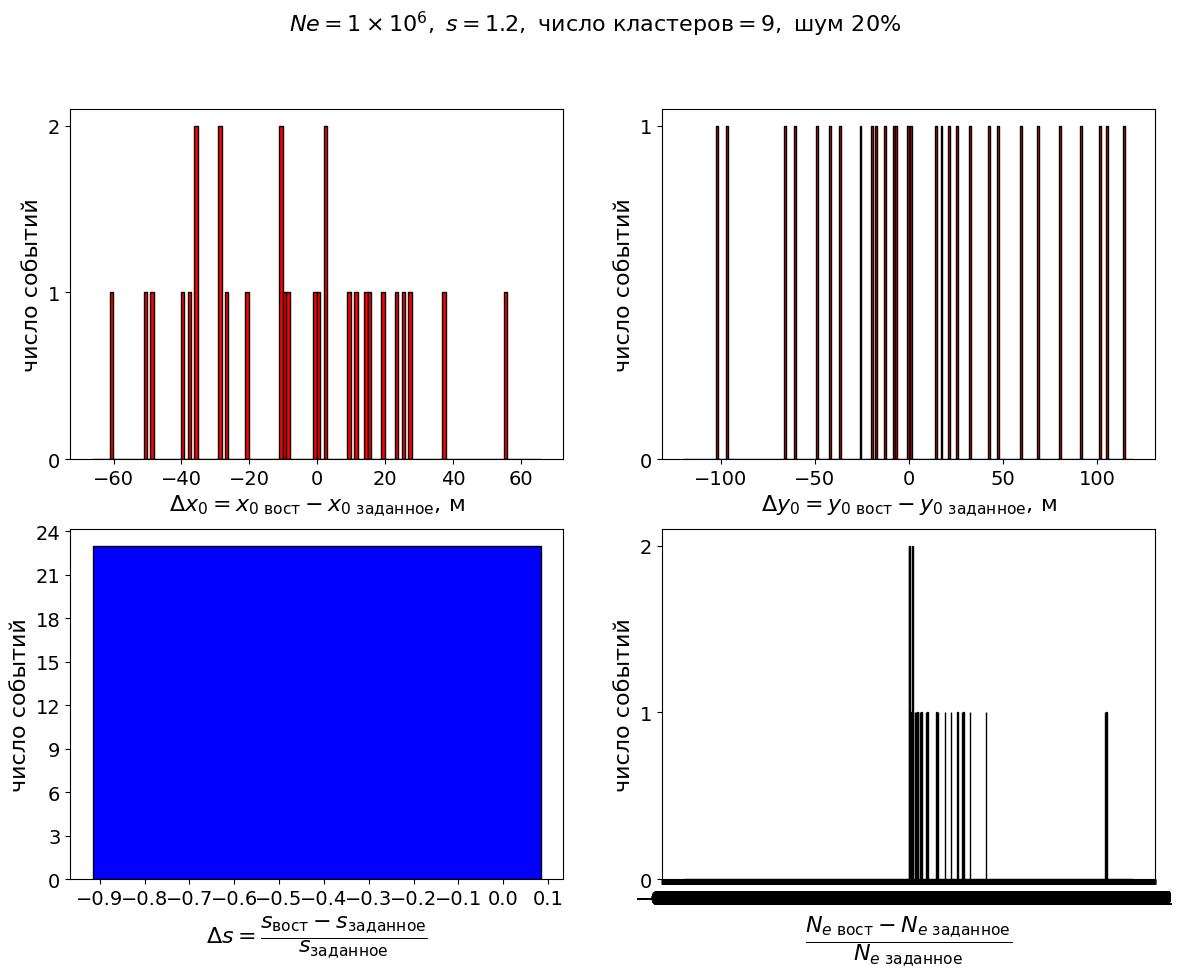

In [130]:
indices = np.where(np.array(events_mask))[0]
delta_X0 = np.array(X0_opt_array)[indices] - np.array(X0_array)[indices]
delta_Y0 = np.array(Y0_opt_array)[indices] - np.array(Y0_array)[indices]
delta_Ne = [(Ne_opt - Ne) / Ne for Ne_opt in np.array(Ne_opt_array)[indices]]
delta_s = [(s_opt - s) / s for s_opt in np.array(s_opt_array)[indices]]

interval_delta_X = 1
interval_delta_Y = 1

interval_delta_s = 1
interval_delta_Ne = 1

limit_X, limit_Y = find_limit(delta_X0), find_limit(delta_Y0)
limit_Ne, limit_s = find_limit(delta_Ne), find_limit(delta_s)

bin_edges_delta_X = np.arange(-limit_X - 5, limit_X + 5, interval_delta_X)
bin_edges_delta_Y = np.arange(-limit_Y - 5, limit_Y + 5, interval_delta_Y)

bin_edges_delta_s = np.arange(-limit_s - 0.1, limit_s + 0.15, interval_delta_s)
bin_edges_delta_Ne = np.arange(-limit_Ne - 0.05, limit_Ne + 0.1, interval_delta_Ne)


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(r'$Ne=1\times10^6,\ s=1.2,\ \text{число кластеров}=9,\ \text{шум}\ 20\%$', fontsize=16)
# delta_X
axes[0, 0].hist(delta_X0, bins=bin_edges_delta_X,
                edgecolor='black', color='red', label=f'размер интервала: {interval_delta_X}')
axes[0, 0].set_xlabel(
    r'$\Delta x_0 = x_{0~\text{вост}} - x_{0~\text{заданное}}$, м', fontsize=16)
axes[0, 0].set_ylabel("число событий", fontsize=16)
axes[0, 0].tick_params(axis='both', which='major', labelsize=14) 


# delta_Y
axes[0, 1].hist(delta_Y0, bins=bin_edges_delta_Y,
                edgecolor='black', color='red', label=f'размер интервала: {interval_delta_Y}')
axes[0, 1].set_xlabel(
    r'$\Delta y_0 = y_{0~\text{вост}} - y_{0~\text{заданное}}$, м', fontsize=16)
axes[0, 1].set_ylabel("число событий", fontsize=16)
axes[0, 1].tick_params(axis='both', which='major', labelsize=14) 
# delta_s
axes[1, 0].hist(delta_s, bins=bin_edges_delta_s, edgecolor='black',
                color='blue', label=f'размер интервала: {interval_delta_s}')
axes[1, 0].set_xlabel(
    r'$\Delta s = \dfrac{s_{\text{вост}} - s_{\text{заданное}}}{s_{\text{заданное}}}$',  fontsize=16)
axes[1, 0].set_ylabel("число событий",  fontsize=16)
axes[1, 0].tick_params(axis='both', which='major', labelsize=14)
axes[1, 0].xaxis.set_major_locator(ticker.MultipleLocator(0.1)) 
# delta_Ne
axes[1, 1].hist(delta_Ne, bins=bin_edges_delta_Ne,
                edgecolor='black', color='green', label=f'размер интервала: {interval_delta_Ne}')
axes[1, 1].set_xlabel(
    r'$\dfrac{N_{e~\text{вост}} - N_{e~\text{заданное}}}{N_{e~\text{заданное}}}$',  fontsize=16)
axes[1, 1].set_ylabel("число событий",  fontsize=16)
axes[1, 1].tick_params(axis='both', which='major', labelsize=14) 
axes[1, 1].xaxis.set_major_locator(ticker.MultipleLocator(0.1)) 
for ax in axes.flat:
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# data = pd.DataFrame(
#     {'delta_r': np.array(delta_r).reshape(-1, 36).tolist, 'delta_s': delta_s, 'delta_Ne': delta_Ne})
# data.to_csv(f'plots/{model_number}/delta_r,s,Ne.csv', index=False)

# plt.tight_layout()
# plt.savefig(
#     f'plots_testing/central_stations/Ne=1e6_s=1.2/delta_r,s=1.2,Ne=1e6,clasters=5_noise0{noise_level}_legendoff.png',
#     dpi=1200,                     # Разрешение 
#     bbox_inches='tight',          # Обрезка пустых полей
#     pad_inches=0.1,               # Отступ внутри bbox_inches
#     format='png',                 # Формат 
#     facecolor='white',            # Фон 
#     edgecolor='none',             # Убрать границу вокруг
# )

# # fig.legend()
# plt.savefig(f'plots_testing/Ne=1e6_s=1.2/delta_r,s=1.2,Ne=1e6,clasters=5_noise0{noise_level}.png',
#             dpi=500, bbox_inches="tight")
plt.show()

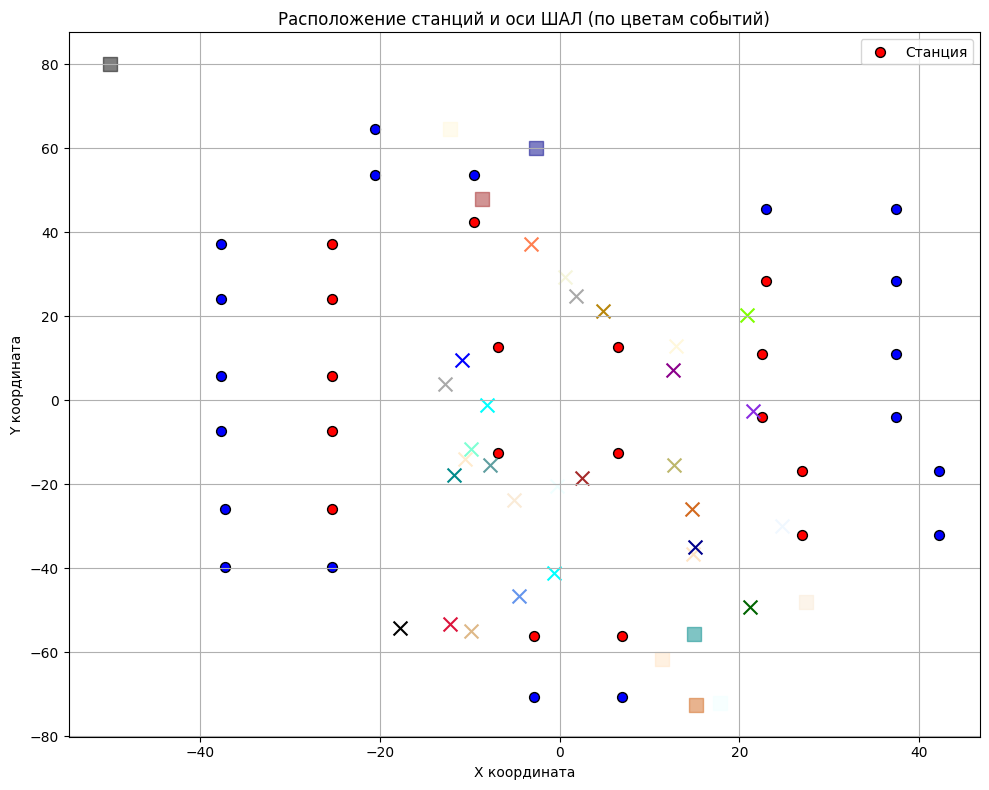

In [129]:
num_events = len(X0_array[events_mask])
colors = list(mcolors.TABLEAU_COLORS.values())  # Список предопределенных цветов
if num_events > len(colors):
    colors = list(mcolors.CSS4_COLORS.values())  # Если событий больше, берем больше цветов

# Создание 2D-графика
fig, ax = plt.subplots(figsize=(10, 8))

# Отображение станций
for _, row in df.iterrows():
    color = "red" if row["station"] in central_stations else "blue"
    ax.scatter(row["X"], row["Y"], color=color, edgecolors="black", s=50, label="Станция" if _ == 0 else "")

# Отображение оси ШАЛ (по цвету события)
for i in range(num_events):
    event_color = colors[i % len(colors)]  # Выбираем цвет для события
    ax.scatter(X0_array[events_mask][i], Y0_array[events_mask][i], 
               color=event_color, marker="x", s=100, alpha=1)
    ax.scatter(X0_opt_array[i], Y0_opt_array[i], 
               color=event_color, marker="s", s=100, alpha=0.5)

# Подписи и оформление
ax.set_xlabel("X координата")
ax.set_ylabel("Y координата")
ax.set_title("Расположение станций и оси ШАЛ (по цветам событий)")
ax.legend()
ax.grid(True)

plt.tight_layout()
# plt.savefig(
#     f'plots_testing/central_stations//Ne=1e6_s=1.2/stations_grid_Ne=1e6,s=1,2_noise=02.png',
#     dpi=1200,                     # Разрешение 
#     bbox_inches='tight',          # Обрезка пустых полей
#     pad_inches=0.1,               # Отступ внутри bbox_inches
#     format='png',                 # Формат 
#     facecolor='white',            # Фон 
#     edgecolor='none',             # Убрать границу вокруг
# )
plt.show()

d:\github\repositories\sdf\corsika\functions.py:29: RuntimeWarning: divide by zero encountered in power
  term2 = (r / r_m) ** (s - 2)


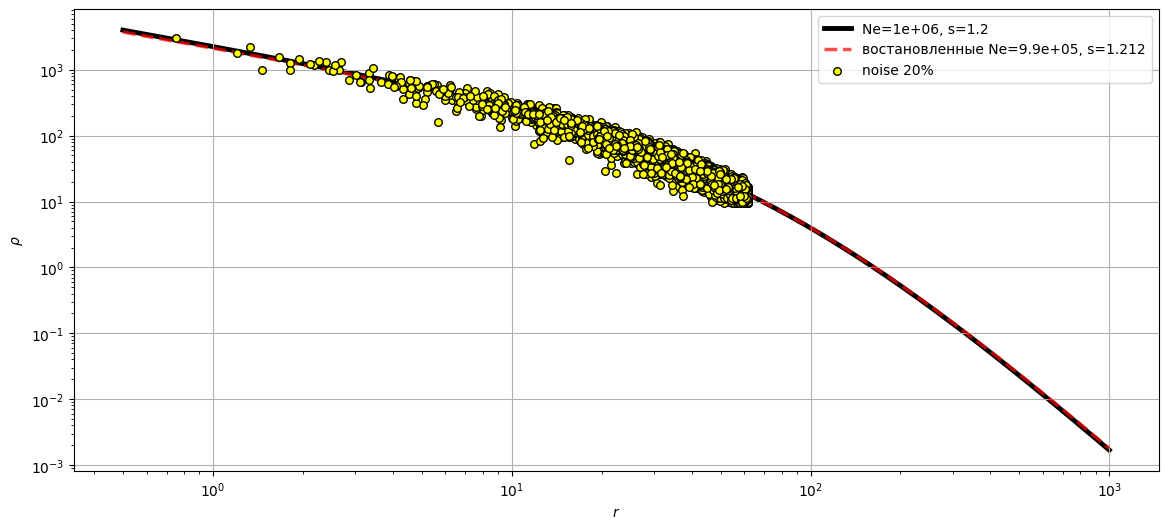

In [106]:
r = np.arange(0, 1e3, 0.5)
rho = rho_model(r, Ne, s)

Ne_opt = np.median(Ne_opt_array)
s_opt = np.median(s_opt_array)
rho_opt = rho_model(r, Ne_opt, s_opt)

all_r = np.concatenate(r_array)
all_rho = np.concatenate(rho_noisy_array)

plt.figure(figsize=(14, 6))
plt.plot(r, rho, 
         label=f"Ne={Ne:.0e}, s={s}",
         color='black',
         linestyle='-',
         linewidth=3.5,
         alpha=1,
         zorder=1)

plt.plot(r, rho_opt,
         label=f"востановленные Ne={Ne_opt:.1e}, s={s_opt:.3f}", 
         color='red',
         linestyle='--',
         linewidth=2.5,
         alpha=0.7,
         zorder=2)

plt.scatter(all_r, all_rho,
            label=f"noise {noise_level}%",
            marker='o',
            s=30,
            color='yellow',
            edgecolor='black',
            alpha=1,
            zorder=3)


plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho$")
plt.legend()
plt.grid(True)
plt.savefig(f'plots_testing/central_stations//Ne=1e6_s=1.2/rho(r),Ne=1e6,clasters=5_noise0{noise_level}.png',
            dpi=500, bbox_inches="tight")
plt.show()